In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# загружаем данные
df = pd.read_csv('milk production.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print('shape:', df.shape)

shape: (168, 1)


D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


Создадим новый ряд значений среднего дневного уровня производства молока в фунтах на одну корову

, поделив на число дней в месяце (вычисляется с помощью функции monthrange из пакета calendar). Постройте график полученного ряда; какой из приведённых ниже графиков у вас получился?

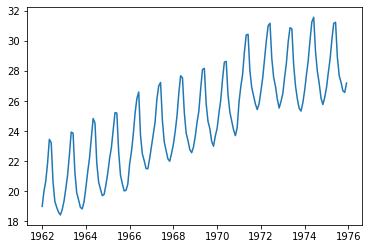

In [4]:
fig, axs = plt.subplots()
df['adjmilk'] = df['milk'].values / df['milk'].index.days_in_month
axs.plot(df['milk'].index, df['adjmilk'])

Критерий Дики-Фуллера

In [5]:
import statsmodels.api as sm

sm.tsa.stattools.adfuller(df['adjmilk'])

(-1.1798216373266037,
 0.682215151308144,
 12,
 155,
 {'1%': -3.4732590518613002,
  '5%': -2.880374082105334,
  '10%': -2.5768120811654525},
 -1.5708067458066353)

p=0.68, поэтому ряд нестационарен. Для ряда со средним дневным количеством молока на корову с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

In [6]:
# применим сезонное дифференцирование, так как из графика видно, что
# временной ряд имеет сезонный характер
df['adjmilk_diff'] = df['adjmilk'] - df['adjmilk'].shift(12)
df['adjmilk_diff'].isna().sum()

12

In [7]:
# подавая полученные данные на вход критерию Дики-Фуллера отрежем значения null
sm.tsa.stattools.adfuller(df['adjmilk_diff'].dropna())

(-2.1594860932888076,
 0.22127672658830383,
 12,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -25.225679141303317)

In [8]:
# применим однократное дифференцирование
df['adjmilk_diff'] = df['adjmilk_diff'] - df['adjmilk_diff'].shift(1)
sm.tsa.stattools.adfuller(df['adjmilk_diff'].dropna())

(-5.481326334796932,
 2.2808455518036712e-06,
 11,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -20.90513750989237)

Получили стационарный временной ряд. Построим график автокорреляционной функции

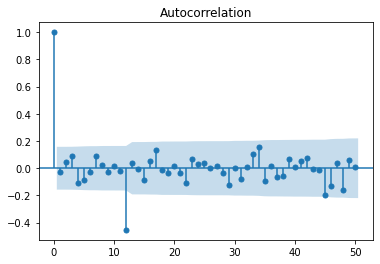

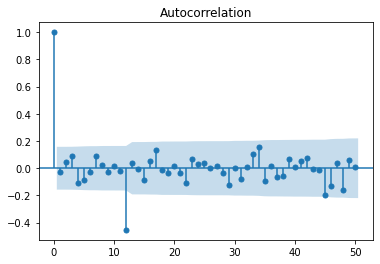

In [9]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['adjmilk_diff'].dropna().squeeze(), lags=50)

Подберем параметры модели SARIMA(p,d,q) x (P, D, Q). \
Видно, что номер последнего сезонного лага, при котором автокорреляция значима равна 12, так что в качестве Q = 1.

Построим график частичной автокорреляционной функции

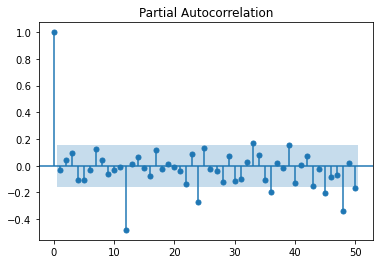

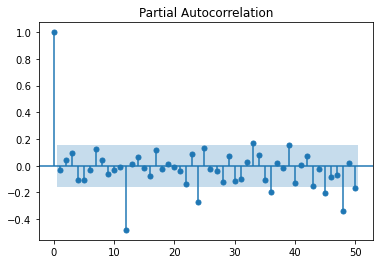

In [10]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(df['adjmilk_diff'].dropna().squeeze(), lags=50)